In [1]:
PATH=%env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/home/jarekk/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/opt/conda/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games


# Training and Serving a TensorFlow Model to AI Platform Prediction

This notebooks trains a TensorFlow classification model locally, using the Keras API, and deploys the model to AI Platform for online prediction. The AI Platform model service is also configered to enable request-response logging to BigQuery.

Note that the aim is to build and deploy a **minimal model** to showcase the AI Platform **logging capabilities**, which enable **skew detection** on the serving data and the produced predictions.

The notebook covers the following steps:

1. Prepare the data and generate metadata 
2. Train and evaluate, a TensorFlow classification model using Keras API
3. Export the trained model as a SavedModel for serving
4. Deploy the trained model to AI Platform Prediction 
5. Enabled request-response logging to BigQuery
6. Parse and query logs from BigQuery


This example uses **TensorFlow 2.x**

### Setup

In [2]:
import os
import pandas as pd
import tensorflow as tf

print("TF version: {}".format(tf.__version__))

TF version: 2.2.0


In [3]:
PROJECT = 'mlops-dev-env'
BUCKET =  'mlops-dev-workspace'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
LOCAL_WORKSPACE = '/home/jarekk/workspace'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
BQ_DATASET_NAME = 'data_validation'
BQ_TABLE_NAME = 'covertype_logs_tf'
MODEL_NAME = 'covertype_tf'
VERSION_NAME = 'v3'
TRAINING_DIR = os.path.join(LOCAL_WORKSPACE, 'training')
MODEL_DIR = os.path.join(TRAINING_DIR, 'exported_model')

**Set the following variables to match your GCP environment**:

In [4]:
!gcloud config set project {PROJECT}

Updated property [core/project].


Create a local workspace

In [5]:
if tf.io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf.io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf.io.gfile.makedirs(LOCAL_WORKSPACE)
tf.io.gfile.makedirs(LOCAL_DATA_DIR)

Removing previous workspace artifacts...
Creating a new workspace...


## 1. Dataset preparation and schema generation

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

### 1.1. Download the data

In [6]:
LOCAL_TRAIN_DATA = os.path.join(LOCAL_DATA_DIR, 'train.csv') 
LOCAL_EVAL_DATA = os.path.join(LOCAL_DATA_DIR, 'eval.csv') 

In [7]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_TRAIN_DATA}
!gsutil cp gs://workshop-datasets/covertype/data_validation/evaluation/dataset.csv {LOCAL_EVAL_DATA}
!wc -l {LOCAL_TRAIN_DATA}

Copying gs://workshop-datasets/covertype/data_validation/training/dataset.csv...

Operation completed over 1 objects/22.2 MiB.                                     
Copying gs://workshop-datasets/covertype/data_validation/evaluation/dataset.csv...

Operation completed over 1 objects/3.9 MiB.                                      
431010 /home/jarekk/workspace/data/train.csv


In [8]:
sample = pd.read_csv(LOCAL_TRAIN_DATA).head()
sample.T

,0,1,2,3,4
Elevation,3034,2827,2854,3188,3091
Aspect,235,26,27,156,61
Slope,13,16,12,13,8
Horizontal_Distance_To_Hydrology,655,85,484,175,134
Vertical_Distance_To_Hydrology,134,13,22,28,10
Horizontal_Distance_To_Roadways,5799,3511,618,3666,1390
Hillshade_9am,197,211,215,235,227
Hillshade_Noon,251,204,214,241,223
Hillshade_3pm,190,125,134,134,129
Horizontal_Distance_To_Fire_Points,4094,6008,1295,1719,2868


### 1.2 Define metadata

In [9]:
HEADER = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
          'Cover_Type']

COLUMN_DEFAULTS = [tf.float32, tf.float32, tf.float32, tf.float32,
                   tf.float32, tf.float32,
                   tf.float32, tf.float32, tf.float32,
                   tf.float32, tf.float32, tf.string, tf.string]

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = ['0', '1', '2', '3', '4', '5', '6']

NUMERIC_FEATURE_NAMES = ['Aspect', 'Elevation', 'Hillshade_3pm', 
                         'Hillshade_9am', 'Hillshade_Noon', 
                         'Horizontal_Distance_To_Fire_Points',
                         'Horizontal_Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways','Slope',
                         'Vertical_Distance_To_Hydrology']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    'Soil_Type': ['2702', '2703', '2704', '2705', '2706', '2717', '3501', '3502', 
                  '4201', '4703', '4704', '4744', '4758', '5101', '6101', '6102', 
                  '6731', '7101', '7102', '7103', '7201', '7202', '7700', '7701', 
                  '7702', '7709', '7710', '7745', '7746', '7755', '7756', '7757', 
                  '7790', '8703', '8707', '8708', '8771', '8772', '8776'], 
    'Wilderness_Area': ['Cache', 'Commanche', 'Neota', 'Rawah']
}

FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()) + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

## 2. Model training and evaluation

### 2.1. Implement data input pipeline

In [10]:
RANDOM_SEED = 19830610
import multiprocessing

def create_dataset(file_pattern, 
                  batch_size=128, num_epochs=1, shuffle=False):
  
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        column_names=HEADER,
        column_defaults=HEADER_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        field_delim=',',
        header=True,
        num_epochs=num_epochs,
        shuffle=shuffle,
        shuffle_buffer_size=(5 * batch_size),
        shuffle_seed=RANDOM_SEED,
        num_parallel_reads=multiprocessing.cpu_count(),
        sloppy=True,
    )
    return dataset.cache()

In [11]:
index = 1
for batch in create_dataset(LOCAL_TRAIN_DATA, batch_size=5, shuffle=False).take(2):
  print("Batch: {}".format(index))
  print("========================")
  record, target = batch
  print("Input features:")
  for key in record:
    print(" - {}:{}".format(key, record[key].numpy()))
  print("Target: {}".format(target))
  index += 1
  print()

Batch: 1
Input features:
 - Elevation:[3034. 2827. 2854. 3188. 3091.]
 - Aspect:[235.  26.  27. 156.  61.]
 - Slope:[13. 16. 12. 13.  8.]
 - Horizontal_Distance_To_Hydrology:[655.  85. 484. 175. 134.]
 - Vertical_Distance_To_Hydrology:[134.  13.  22.  28.  10.]
 - Horizontal_Distance_To_Roadways:[5799. 3511.  618. 3666. 1390.]
 - Hillshade_9am:[197. 211. 215. 235. 227.]
 - Hillshade_Noon:[251. 204. 214. 241. 223.]
 - Hillshade_3pm:[190. 125. 134. 134. 129.]
 - Horizontal_Distance_To_Fire_Points:[4094. 6008. 1295. 1719. 2868.]
 - Wilderness_Area:[b'Rawah' b'Rawah' b'Commanche' b'Commanche' b'Commanche']
 - Soil_Type:[b'7745' b'7745' b'4704' b'7756' b'7202']
Target: [1. 1. 1. 1. 0.]

Batch: 2
Input features:
 - Elevation:[2993. 3276. 2864. 3183. 2587.]
 - Aspect:[ 35. 343. 319. 138.  80.]
 - Slope:[ 8. 11. 29. 23.  5.]
 - Horizontal_Distance_To_Hydrology:[636. 849. 228. 268. 234.]
 - Vertical_Distance_To_Hydrology:[ 90. -14.  98.  85.  28.]
 - Horizontal_Distance_To_Roadways:[3355. 1776.

### 2.2. Create feature columns

In [12]:
import math

def create_feature_columns():
  feature_columns = []
  
  for feature_name in FEATURE_NAMES:
    # Categorical features
    if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
      
      vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
      vocab_size = len(vocabulary)
      
      # Create embedding column for categotical feature column with vocabulary
      embedding_feature_column = tf.feature_column.embedding_column(
          categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
              key=feature_name,
              vocabulary_list=vocabulary), dimension=int(math.sqrt(vocab_size) + 1))
            
      feature_columns.append(embedding_feature_column)

    # Numeric features
    else:
      numeric_column = tf.feature_column.numeric_column(feature_name)
      feature_columns.append(numeric_column)

  return feature_columns


In [13]:
feature_columns = create_feature_columns()

for column in feature_columns:
  print(column)

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Soil_Type', vocabulary_list=('2702', '2703', '2704', '2705', '2706', '2717', '3501', '3502', '4201', '4703', '4704', '4744', '4758', '5101', '6101', '6102', '6731', '7101', '7102', '7103', '7201', '7202', '7700', '7701', '7702', '7709', '7710', '7745', '7746', '7755', '7756', '7757', '7790', '8703', '8707', '8708', '8771', '8772', '8776'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=7, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fdf30fad690>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Wilderness_Area', vocabulary_list=('Cache', 'Commanche', 'Neota', 'Rawah'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=3, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object a

### 2.3. Create and compile the model



In [14]:
def create_model(params):

  feature_columns = create_feature_columns()
  
  layers = []
  layers.append(tf.keras.layers.DenseFeatures(feature_columns))
  for units in params.hidden_units:
    layers.append(tf.keras.layers.Dense(units=units, activation='relu'))
    layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Dropout(rate=params.dropout))
  
  layers.append(tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='output'))
  
  model = tf.keras.Sequential(layers=layers, name='classifier')
    
  adam_optimzer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)

  model.compile(
        optimizer=adam_optimzer, 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], 
        loss_weights=None,
        sample_weight_mode=None, 
        weighted_metrics=None, 
    )

  return model  

### 2.4. Train and evaluate experiment

#### Experiment

In [15]:
def run_experiment(model, params):

  # TensorBoard callback
  LOG_DIR = os.path.join(TRAINING_DIR, 'logs')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

  # Early stopping callback
  earlystopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_sparse_categorical_accuracy', 
      patience=3, 
      restore_best_weights=True
  )

  callbacks = [
        tensorboard_callback,
        earlystopping_callback]

  # train dataset
  train_dataset = create_dataset(
      LOCAL_TRAIN_DATA,
      batch_size=params.batch_size,
      shuffle=True)
    
  # eval dataset
  eval_dataset = create_dataset(
      LOCAL_EVAL_DATA,
      batch_size=params.batch_size)
    
  # Prep training directory
  if tf.io.gfile.exists(TRAINING_DIR):
    print("Removing previous training artefacts...")
    tf.io.gfile.rmtree(TRAINING_DIR)

  print("Creating training directory...")
  tf.io.gfile.mkdir(TRAINING_DIR)

  print("Experiment started...")
  print(".......................................")
  
  # Run train and evaluate.
  history = model.fit(
    x=train_dataset, 
    epochs=params.epochs, 
    callbacks=callbacks,
    validation_data=eval_dataset,
  )

  print(".......................................")
  print("Experiment finished.")
  print("")

  return history


#### Hyper parameters

In [16]:
class Parameters():
    pass

TRAIN_DATA_SIZE = 431010

params = Parameters()
params.learning_rate = 0.01
params.hidden_units = [128, 128]
params.dropout = 0.15
params.batch_size =  265
params.steps_per_epoch = int(math.ceil(TRAIN_DATA_SIZE / params.batch_size))
params.epochs = 10

#### Run experiment

In [17]:
model = create_model(params)
example_batch, _ = list(
    create_dataset(LOCAL_TRAIN_DATA, batch_size=2, shuffle=True).take(1))[0]
model(example_batch)
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  285       
_________________________________________________________________
dense (Dense)                multiple                  2688      
_________________________________________________________________
batch_normalization (BatchNo multiple                  512       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0

In [18]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

history = run_experiment(model, params)

Creating training directory...
Experiment started...
.......................................
Epoch 1/10
1627/1627 [==============================] - 17s 11ms/step - loss: 0.6654 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7909 - val_sparse_categorical_accuracy: 0.6444
Epoch 2/10
1627/1627 [==============================] - 11s 7ms/step - loss: 0.5955 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.7121
Epoch 3/10
1627/1627 [==============================] - 11s 7ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.5392 - val_sparse_categorical_accuracy: 0.7628
Epoch 4/10
1627/1627 [==============================] - 10s 6ms/step - loss: 0.5553 - sparse_categorical_accuracy: 0.7610 - val_loss: 0.5193 - val_sparse_categorical_accuracy: 0.7758
Epoch 5/10
1627/1627 [==============================] - 10s 6ms/step - loss: 0.5450 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.5065 - val_sparse_categorical_accuracy

#### Visualize training history

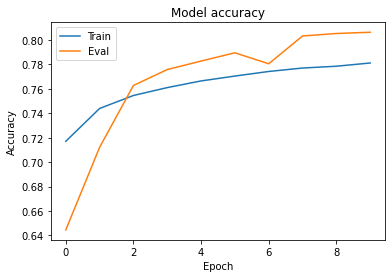

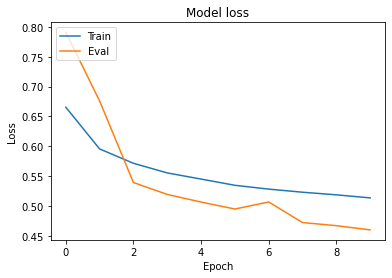

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper left')
plt.show()

## 3. Model export for serving

### 3.2. Export the model

In [20]:
SIGNATURE_NAME = 'serving_default'

model.save(MODEL_DIR, save_format='tf')
print("Model is exported to: {}.".format(MODEL_DIR))

Model is exported to: /home/jarekk/workspace/training/exported_model.


In [21]:
!saved_model_cli show --dir {MODEL_DIR} --tag_set serve 

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [22]:
!saved_model_cli show --dir {MODEL_DIR} --tag_set serve --signature_def {SIGNATURE_NAME}

The given SavedModel SignatureDef contains the following input(s):
  inputs['Aspect'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Aspect:0
  inputs['Elevation'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Elevation:0
  inputs['Hillshade_3pm'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Hillshade_3pm:0
  inputs['Hillshade_9am'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Hillshade_9am:0
  inputs['Hillshade_Noon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Hillshade_Noon:0
  inputs['Horizontal_Distance_To_Fire_Points'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Horizontal_Distance_To_Fire_Points:0
  inputs['Horizontal_Distance_To_Hydrology'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_Horizontal_Distance_To_Hydrology:0
  inputs['Ho

### 3.4  Upload exported model to GCS

In [23]:
!gsutil rm -r gs://{BUCKET}/models/{MODEL_NAME}
!gsutil cp -r {MODEL_DIR} gs://{BUCKET}/models/{MODEL_NAME}

Removing gs://mlops-dev-workspace/models/covertype_tf/saved_model.pb#1589992294452117...
Removing gs://mlops-dev-workspace/models/covertype_tf/variables/variables.data-00000-of-00001#1589992294706126...
Removing gs://mlops-dev-workspace/models/covertype_tf/variables/variables.index#1589992294891571...

Operation completed over 3 objects.                                              
Copying file:///home/jarekk/workspace/training/exported_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///home/jarekk/workspace/training/exported_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///home/jarekk/workspace/training/exported_model/variables/variables.index [Content-Type=application/octet-stream]...

Operation completed over 3 objects/1.2 MiB.                                      


## 4. Model deployment to AI Platform 


### 4.1. Create model in AI Platform

In [24]:
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --regions {REGION} \
  --enable-logging

Created ml engine model [projects/mlops-dev-env/models/covertype_tf].


In [25]:
!gcloud ai-platform models list --project {PROJECT}

NAME                          DEFAULT_VERSION_NAME
covertype_classifier_sklearn  v1
covertype_classifier_tf       v2
covertype_tf
tf_example_test               v1


### 4.2. Create a model version

In [26]:
VERSION_CONFIG = 'model_version_config.yaml'

In [27]:
%%writefile {VERSION_CONFIG}

framework: 'TENSORFLOW'
pythonVersion: '3.7'
runtimeVersion: '2.1'
manualScaling:
  nodes: 1
machineType: 'n1-standard-16'


Writing model_version_config.yaml


In [28]:
!cat {VERSION_CONFIG}


framework: 'TENSORFLOW'
pythonVersion: '3.7'
runtimeVersion: '2.1'
manualScaling:
  nodes: 1
machineType: 'n1-standard-16'


In [29]:
!gcloud ai-platform versions create {VERSION_NAME} \
  --model={MODEL_NAME} \
  --origin=gs://{BUCKET}/models/{MODEL_NAME} \
  --project={PROJECT} \
  --config={VERSION_CONFIG}

!gcloud ai-platform versions list --model={MODEL_NAME} --project={PROJECT}

Creating version (this might take a few minutes)......done.
NAME  DEPLOYMENT_URI                                STATE
v3    gs://mlops-dev-workspace/models/covertype_tf  READY


### 4.3. Test deployed model

In [30]:
import googleapiclient.discovery

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)
print("Service name: {}".format(name))

def caip_predict(instances):
    
  request_body={
      'signature_name': SIGNATURE_NAME,
      'instances': instances}

  response = service.projects().predict(
      name=name,
      body=request_body

  ).execute()

  if 'error' in response:
    raise RuntimeError(response['error'])

  return response['predictions']

Service name: projects/mlops-dev-env/models/covertype_tf/versions/v3


In [31]:
instances = [
      { 
        'Soil_Type': ['7202'],
        'Wilderness_Area': ['Commanche'],
        'Aspect': [61],
        'Elevation': [3091],
        'Hillshade_3pm': [129],
        'Hillshade_9am': [227],
        'Hillshade_Noon': [223],
        'Horizontal_Distance_To_Fire_Points': [2868],
        'Horizontal_Distance_To_Hydrology': [134],
        'Horizontal_Distance_To_Roadways': [0], 
        'Slope': [8], 
        'Vertical_Distance_To_Hydrology': [10],
    }
]

caip_predict(instances)

[[0.00579777407,
  0.994201124,
  1.01245214e-10,
  3.44565418e-11,
  9.99651547e-07,
  1.28816724e-09,
  1.04677639e-07]]

## 5. BigQuery logging dataset preparation

### 5.1. Create BQ Dataset

In [32]:
from google.cloud import bigquery

client = bigquery.Client(PROJECT)
dataset_names = [dataset.dataset_id for dataset in client.list_datasets(PROJECT)]

dataset = bigquery.Dataset("{}.{}".format(PROJECT, BQ_DATASET_NAME))
dataset.location = "US"

if BQ_DATASET_NAME not in dataset_names:
  dataset = client.create_dataset(dataset)
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

print("BigQuery Dataset is ready.")

BigQuery Dataset is ready.


### 5.2. Create BQ Table


#### Table schema

In [33]:
import json

table_schema_json = [
  {
    "name": "model", 
    "type": "STRING", 
    "mode": "REQUIRED"
   },
   {
     "name":"model_version", 
     "type": "STRING", 
     "mode":"REQUIRED"
  },
  {
    "name":"time", 
    "type": "TIMESTAMP", 
    "mode": "REQUIRED"
  },
  {
    "name":"raw_data", 
    "type": "STRING", 
    "mode": "REQUIRED"
  },
  {
    "name":"raw_prediction", 
    "type": "STRING", 
    "mode": "NULLABLE"
  },
  {
    "name":"groundtruth", 
    "type": "STRING", 
    "mode": "NULLABLE"
  },
]

json.dump(table_schema_json, open('table_schema.json', 'w'))

#### Ceating an ingestion-time partitioned tables

In [34]:
table = bigquery.Table(
    "{}.{}.{}".format(PROJECT, BQ_DATASET_NAME, BQ_TABLE_NAME))

table_names = [table.table_id for table in client.list_tables(dataset)]

if BQ_TABLE_NAME in table_names:
  print("Deleteing BQ Table: {} ...".format(BQ_TABLE_NAME))
  client.delete_table(table)

# table = client.create_table(table)
# table.partition_expiration = 60 * 60 * 24 * 7
# print("Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id))


In [35]:
TIME_PARTITION_EXPERIATION = 60 * 60 * 24 * 7 # week

!bq mk --table \
  --project_id={PROJECT} \
  --time_partitioning_type=DAY \
  --time_partitioning_expiration {TIME_PARTITION_EXPERIATION} \
  {PROJECT}:{BQ_DATASET_NAME}.{BQ_TABLE_NAME} \
  'table_schema.json'

Table 'mlops-dev-env:data_validation.covertype_logs_tf' successfully created.


### 5.3. Configre the AI Platform model version to enable request-response logging to BigQuery

In [47]:
sampling_percentage = 1.0
bq_full_table_name = '{}.{}.{}'.format(PROJECT, BQ_DATASET_NAME, BQ_TABLE_NAME)

In [48]:
logging_config = {
    "requestLoggingConfig":{
        "samplingPercentage": sampling_percentage,
        "bigqueryTableName": bq_full_table_name
        }
    }

response = service.projects().models().versions().patch(
    name=name,
    body=logging_config,
    updateMask="requestLoggingConfig"
    ).execute()

response

{'name': 'projects/mlops-dev-env/operations/update_covertype_tf_v3_1591202609599',
 'metadata': {'@type': 'type.googleapis.com/google.cloud.ml.v1.OperationMetadata',
  'createTime': '2020-06-03T16:43:29Z',
  'operationType': 'UPDATE_VERSION',
  'modelName': 'projects/mlops-dev-env/models/covertype_tf',
  'version': {'name': 'projects/mlops-dev-env/models/covertype_tf/versions/v3',
   'deploymentUri': 'gs://mlops-dev-workspace/models/covertype_tf',
   'createTime': '2020-06-03T15:21:40Z',
   'runtimeVersion': '2.1',
   'manualScaling': {'nodes': 1},
   'state': 'READY',
   'etag': 'aiw6VGmzOo8=',
   'framework': 'TENSORFLOW',
   'machineType': 'n1-standard-16',
   'pythonVersion': '3.7',
   'requestLoggingConfig': {'samplingPercentage': 1,
    'bigqueryTableName': 'mlops-dev-env.data_validation.covertype_logs_tf'}}},
 'done': True,
 'response': {'@type': 'type.googleapis.com/google.cloud.ml.v1.Version',
  'name': 'projects/mlops-dev-env/models/covertype_tf/versions/v3',
  'isDefault': T

### 5.4. Test request-response logging

In [49]:
import time

for i in range(5):
  caip_predict(instances)
  print('.', end='')
  time.sleep(0.25)

.....

In [50]:
query = '''
  SELECT * FROM 
  `{}.{}` 
  WHERE model_version = '{}'
  ORDER BY time desc
  LIMIT {}
'''.format(BQ_DATASET_NAME, BQ_TABLE_NAME, VERSION_NAME, 3)

pd.io.gbq.read_gbq(
    query, project_id=PROJECT).T


Downloading: 100%|██████████| 3/3 [00:00<00:00,  9.00rows/s]


,0,1,2
model,covertype_tf,covertype_tf,covertype_tf
model_version,v3,v3,v3
time,2020-06-03 16:44:12+00:00,2020-06-03 16:44:12+00:00,2020-06-03 16:44:11+00:00
raw_data,"{""signature_name"": ""serving_default"", ""instanc...","{""signature_name"": ""serving_default"", ""instanc...","{""signature_name"": ""serving_default"", ""instanc..."
raw_prediction,"{\n ""predictions"": [[0.00579777407, 0.99420...","{\n ""predictions"": [[0.00579777407, 0.99420...","{\n ""predictions"": [[0.00579777407, 0.99420..."
groundtruth,None,None,None
